In [1]:
import warnings

from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
%%capture

from ding0.core import NetworkDing0
from ding0.tools.logger import setup_logger
from ding0.tools.results import save_nd_to_pickle
from ding0.tools.plots import plot_mv_topology
from egoio.tools import db
from sqlalchemy.orm import sessionmaker
import oedialect

from ding0.tools import results # to load pickl file


# create new network
nd = NetworkDing0(name='network')


# set ID of MV grid district
mv_grid_districts = [40] # fn 40, 912

#### SET DING0 SETTINGS

In [3]:
# TODO set in config file
ding0_default=False

In [4]:
engine = db.connection(section='oedb_dialect', readonly=True)
session = sessionmaker(bind=engine)()

In [5]:
create_lvgd_geo_method='convex_hull' # off, convex_hull

In [6]:
%%time

# STEP 1
lv_load_area, mvlv_subst_list, cluster_graph = nd.import_mv_grid_districts(session, mv_grid_districts_no=mv_grid_districts,
                            ding0_default=ding0_default, need_parameterization=True,
                            create_lvgd_geo_method=create_lvgd_geo_method)

Finding connected graph, iteration 1 of max. 4.


Simplified graph: 94 to 22 nodes, 170 to 26 edges


bicycle_parking is not matched in config and will be categorized as leftover
bicycle_parking is not matched in config and will be categorized as leftover


Simplified graph: 716 to 479 nodes, 1484 to 1010 edges
at least one node trespasses dist to substation.                                cluster again with n_clusters+=1
after increment; n_cluster 5
all clusters are in range


Wall time: 12.9 s


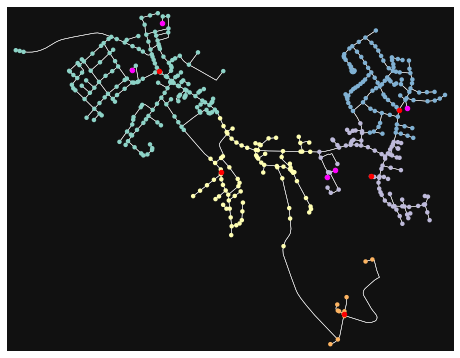

In [9]:
# CLUSTER GRAPH MVTRAFO AT GRAPH
import osmnx as ox

nc = ox.plot.get_node_colors_by_attr(cluster_graph, attr='cluster', cmap="Set3") #

fig, ax = ox.plot_graph(cluster_graph, node_color=nc, node_size=20, edge_color='w', edge_linewidth=0.5, show=False, close=False)

for station in mvlv_subst_list:
    if station.get('load_level') == 'lv':
        ax.scatter(station.get('x'), station.get('y'), color = 'red', s=20)
    else:
        ax.scatter(station.get('x'), station.get('y'), color = 'magenta', s=20)

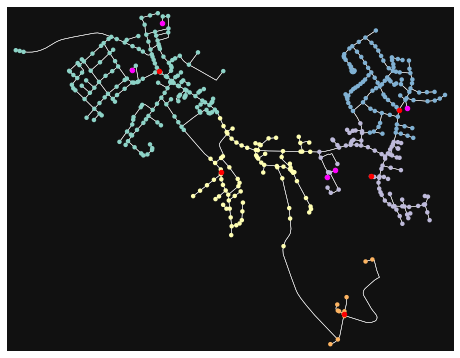

In [11]:
import osmnx as ox


nc = ox.plot.get_node_colors_by_attr(cluster_graph, attr='cluster', cmap="Set3") #

fig, ax = ox.plot_graph(cluster_graph, node_color=nc, node_size=20, edge_color='w', edge_linewidth=0.5, show=False, close=False)

for lvgd in lv_load_area._lv_grid_districts:
    if lvgd.load_level == 'lv':
        # color = 'red'
        ax.scatter(lvgd.lv_grid._station.geo_data.x, lvgd.lv_grid._station.geo_data.y, color = 'red', s=20)
    else:
        # color = 'magenta'
        ax.scatter(lvgd.lv_grid._station.geo_data.x, lvgd.lv_grid._station.geo_data.y, color = 'magenta', s=20)


In [7]:
# STEP 2
nd.import_generators(session, debug=False)

Generator Generator_mvgd_40_lvgd_4347000015_solar_ground_mounted_232522 cannot be assigned to non-existent LV Grid District and was allocated to a random LV Grid District (lv_grid_district_4347000015).
Generator Generator_mvgd_40_lvgd_4347000142_gas_232523 cannot be assigned to non-existent LV Grid District and was allocated to a random LV Grid District (lv_grid_district_4347000142).
Generator Generator_mvgd_40_lvgd_4347000122_hydro_232524 has no la_id and was assigned to a random LV Grid District (lv_grid_district_4347000122).
Generator Generator_mvgd_40_lvgd_4347000247_hydro_232525 has no la_id and was assigned to a random LV Grid District (lv_grid_district_4347000247).
Generator Generator_mvgd_40_lvgd_5511000000_solar_ground_mounted_232526 cannot be assigned to non-existent LV Grid District and was allocated to a random LV Grid District (lv_grid_district_5511000000).
Generator Generator_mvgd_40_lvgd_4347000149_solar_ground_mounted_232527 cannot be assigned to non-existent LV Grid Di

In [8]:
%%time

# STEP 3
nd.mv_parametrize_grid(debug=False)

Wall time: 27 s


In [9]:
# STEP 4: Validate MV Grid Districts
msg = nd.validate_grid_districts()

In [10]:
# STEP 5: Build LV grids
# nd.build_lv_grids()

load_area, bg = nd.build_lv_grids()
lv_loads_grid = bg[0]
lv_loads_to_station = bg[1]
fedder_cable_dict = bg[2]


lv_grid_district_4488000000


In [12]:
lvgd = load_area._lv_grid_districts[0]

In [21]:
from ding0.tools import config as cfg_ding0
cos_phi_load = cfg_ding0.get('assumptions', 'cos_phi_load')

I_max_load = 5500 / (3 ** 0.5 * 10) / cos_phi_load
print('cos_phi_load', cos_phi_load, 'I_max_load', I_max_load)

cos_phi_load 0.97 I_max_load 327.36355469514865


In [22]:
lvgd.lv_grid.network.static_data['MV_cables'].loc[lvgd.lv_grid.network.static_data['MV_cables'].reinforce_only == 0]

,name,U_n,I_max_th,R_per_km,L_per_km,C_per_km,reinforce_only
0,NA2XS2Y 3x1x185 RM/25,10,357,0.164,0.3800,0.410,0
1,NA2XS2Y 3x1x240 RM/25,10,417,0.125,0.3600,0.470,0
5,NA2XS2Y 3x1x150 RE/25,20,319,0.206,0.4011,0.240,0
6,NA2XS2Y 3x1x240,20,417,0.130,0.3597,0.304,0


In [14]:
lvgd.lv_grid.network.static_data['LV_cables']

,U_n,I_max_th,R_per_km,L_per_km
name,,,,
NAYY 4x1x300,400,419,0.100,0.279
NAYY 4x1x240,400,364,0.125,0.254
NAYY 4x1x185,400,313,0.164,0.256
NAYY 4x1x150,400,275,0.206,0.256
NAYY 4x1x120,400,245,0.253,0.256
NAYY 4x1x95,400,215,0.320,0.261
NAYY 4x1x50,400,144,0.449,0.270
NAYY 4x1x35,400,123,0.868,0.271


In [19]:
import osmnx as ox
edges = ox.graph_to_gdfs(load_area._lv_grid_districts[0].graph_district, nodes=False, edges=True)
edges.head(3)

geometry  \
u          v         key                                                      
2274291202 300459659 0    LINESTRING (4275867.035 2730742.302, 4275877.8...   
           300459666 0    LINESTRING (4275877.833 2730732.214, 4275885.7...   
309968943  300459701 0    LINESTRING (4275796.004 2730852.154, 4275815.1...   

                             length        highway     osmid  
u          v         key                                      
2274291202 300459659 0    14.777509    residential  27369553  
           300459666 0    24.127150    residential  27369553  
309968943  300459701 0    24.677732  living_street  27369556

In [21]:
for i, row in edges.iterrows():
    print(i[0], i[1])
    break
i[0], i[1]

2274291202 300459659


(2274291202, 300459659)

In [23]:
node_feeder_dict.get(i[0]), node_feeder_dict.get(i[1])

(1, 1)

In [31]:
# MultiIndex([(2274291202, 300459659, 0)], names=['u', 'v', 'key'])
edges.loc[(2274291202, 300459659, 0)]

geometry    LINESTRING (4275867.035048964 2730742.30236250...
length                                              14.777509
highway                                           residential
osmid                                                27369553
Name: (2274291202, 300459659, 0), dtype: object

In [26]:
edges

geometry  \
u          v          key                                                      
2274291202 300459659  0    LINESTRING (4275867.035 2730742.302, 4275877.8...   
           300459666  0    LINESTRING (4275877.833 2730732.214, 4275885.7...   
309968943  300459705  0    LINESTRING (4275815.187 2730836.630, 4275821.0...   
           300459701  0    LINESTRING (4275796.004 2730852.154, 4275815.1...   
899946546  35239378   0    LINESTRING (4275955.471 2731157.459, 4275964.7...   
...                                                                      ...   
8176569264 8176569265 0    LINESTRING (4276088.113 2731028.521, 4276090.1...   
309951945  309951975  0    LINESTRING (4276004.017 2731370.136, 4276002.8...   
           309951946  0    LINESTRING (4276004.017 2731370.136, 4276002.3...   
35239378   35239379   0    LINESTRING (4275955.471 2731157.459, 4275945.7...   
309951972  309951975  0    LINESTRING (4276002.876 2731350.211, 4276003.1...   

                              length        highway      osmid  
u          v          key                                       
2274291202 300459659  0    14.777509    residential   27369553  
           300459666  0    24.127150    residential   27369553  
309968943  300459705  0     7.264478  living_street   27369556  
           300459701  0    24.677732  living_street   27369556  
899946546  35239378   0    13.085713      secondary  632642382  
...                              ...            ...        ...  
8176569264 8176569265 0     6.528992        service  257543580  
309951945  309951975  0    19.958167        service   28220248  
           309951946  0    62.373310    residential   26180893  
35239378   35239379   0    18.434520      secondary  218151783  
309951972  309951975  0    81.645580        service   28220248  

[176 rows x 4 columns]

In [17]:
lv_grid_district_build[1]

,category,area,geometry,raccordement_building,name,number_households,n_amenities_inside,osm_id_building,geometry_amenity,x,y,capacity,nn,nn_dist,nn_coords,cluster,feeder,n_residential_at_this_feeder
113729971,school,2263.00,"POLYGON ((4275820.767368784 2731206.422305302,...",POINT (4275841.978121648 2731225.391497739),Grundschule Kluftern,0.508475,1.0,NaN,NaN,4.275842e+06,2.731225e+06,140.758600,4474326634,42.574385,POINT (4275839.968844581 2731182.864553),0,2,0.508475
8722698791,library,2831.15,"POLYGON ((4275891.680912562 2731423.106414076,...",POINT (4275910.884412572 2731398.269475583),Ortsbücherei Kluftern,0.833333,2.0,113729970.0,POINT (4275911.679142763 2731407.29853519),4.275911e+06,2.731398e+06,163.923585,1783501474,28.078869,POINT (4275884.3077884 2731389.208242491),0,3,0.833333


### checking unique ways and not di-graph

In [ ]:
import osmnx as ox
import networkx as nx
edges = ox.graph_to_gdfs(lvgd.graph_district, nodes=False, edges=True)
edges

In [ ]:
import osmnx as ox
import networkx as nx
edges = ox.graph_to_gdfs(lvgd.graph_district, nodes=False, edges=True)
edges

,,,length,highway,osmid,geometry
u,v,key,,,,
29585231,2923114678,0,39.462243,residential,37528126,"LINESTRING (4284444.248 2725229.780, 4284454.9..."
2923114678,29585231,0,39.462243,residential,37528126,"LINESTRING (4284444.248 2725229.780, 4284454.9..."


In [19]:
%%time

edges = ox.graph_to_gdfs(nx.MultiGraph(lvgd.graph_district), nodes=False, edges=True)
edges

Wall time: 43 ms


,,,length,highway,osmid,geometry
u,v,key,,,,
29585231,2923114678,0,39.462243,residential,37528126,"LINESTRING (4284444.248 2725229.780, 4284454.9..."


In [21]:
%%time

gg = ox.utils_graph.get_undirected(lvgd.graph_district)
edges = ox.graph_to_gdfs(gg, nodes=False, edges=True)
edges

Wall time: 164 ms


,,,length,highway,osmid,geometry,from,to
u,v,key,,,,,,
29585231,2923114678,0,39.462243,residential,37528126,"LINESTRING (4284444.248 2725229.780, 4284454.9...",2923114678,29585231
